## Optimization Problem Definition


An optimization problem has three main elements:
- design variables
- objective
- constraints

**Design variables** are the variables that we allow the optimizer to change.  We denote these variables as $x$, where $x$ is an array (i.e., there can be many design variables).  For example if we were designing the shape of the spoiler on a car, the design variables might be things like the length of the spoiler, the distance away from the car body, and parameters that define its curved profile.

The **objective** is the metric we want to minimize.  We usually denote this function by $J$ or sometimes $f$.  It is a scalar, meaning a single value (at times it makes sense to have multiple objectives, but the approach is different&mdash;we will explore this later in the semester).  By convention we say minimize because we often minimize things in engineering, but in other disciplines, like finance, the default convention may be to maximize.  This does not mean that the algorithms we explore can can only perform minimization, to maximize you simply minimize the negative of the function ($-J(x)$).  In our car example, the objective of our spoiler design may be to maximize (downward) lift.

**Constraints** exist in almost any engineering problem, they are conditions that we require the optimizer to satisfy.  We denote them with $c$, where $c$ is an array because we may have many constraints.  By convention we will define constraints in this form: $c(x) \le 0$.  This is completely general as a constraint of the form $q(x) \ge 0$ could be rewritten as $c(x) = -q(x) \le 0$.  In our car example the constraints may be things like a constraint on bending stress, manufacturing tolerances, etc.  Without these constraints, our spoiler may produce a lot of lift but may snap in half or be too difficult to manufacture.

In short, we can write all of our optimization problems in this form:

\begin{align*}
\text{minimize} \quad & J(x) \\
\text{with respect to} \quad & x \\
\text{subject to} \quad & c(x) \le 0 \\
\end{align*}


## Example Problem

Let's consider a simple problem called the Rosenbrock problem.  It has two design variables: $x$ and $y$, and an objecive function of:
$$J(x, y) = (1 - x)^2 + 100(y - x^2)^2$$

It's often used as a starting problem for testing optimization algorithms because it is only 2D (so it is easy to visualize), but it has a long valley that is steep in one direction and shallow in the other making it somewhat challenging to optimize.  In fact, let's visualize the function space with a contour plot (which we can do because there are only 2 variables).  First let's create the function. Note that x will be passed into this function as a vector.  This will be necessary later when using the optimization algorithms.

In [ ]:
function [J] = obj(x)

    J = (1 - x(1))^2 + 100*(x(2) - x(1)^2)^2; 
    
end

We can also do this as an inline function (called anonymous function in matlab) because it is so simple.  Anonymous functions functions can only be one-liners):

In [1]:
obj = @(x) (1 - x(1))^2 + 100*(x(2) - x(1)^2)^2; 

Now let's create a contour plot for that function.

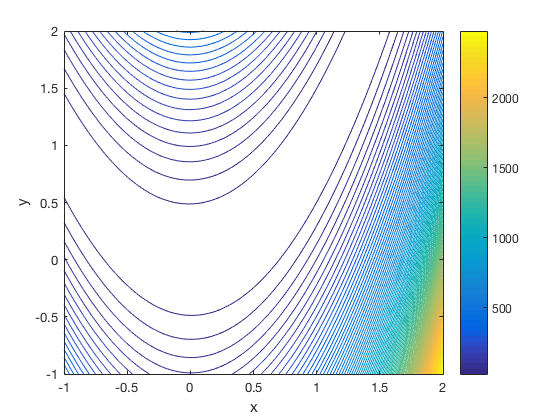

In [6]:
% --- setup grid ---
nx = 200;  % number of points in x-direction
ny = 150;  % number of points in y-direction
x = linspace(-1, 2, nx);  % nx points equally spaced between -5...5
y = linspace(-1, 2, ny);  % ny points equally spaced between -6...6
[X, Y] = ndgrid(x, y);  % 2D array (matrix) of points across x and y
Z = zeros(nx, ny);  % initialize output of size (nx, ny)

% --- evaluate across grid ---
for i = 1:nx
    for j = 1:ny
        Z(i, j) = obj([X(i, j), Y(i, j)]);
    end
end

% --- contour plot ---
figure();  % start a new figure
contour(X, Y, Z, 100);  % using 100 contour lines.  
colorbar();  % add a colorbar
xlabel('x');  % labels for axes
ylabel('y');

Note the flat U-shaped valley.  The minimum is actually at (1, 1).  A couple of other notes on contour plots:
- You can also meshgrid instead of ndgrid. meshgrid works exactly the same, except for the size of the array will be (ny, nx) (backwards from ndgrid) . This is intended to mimic the physical space where the columns go along the x-direction. I prefer ndgrid because I think it’s clearer to use x as the first index and y as the second.
- contourf is the same as contour, except for it creates filled colorbars.

## Using fminunc

Let's find the minimum of the Rosenbrock function.  This problem is unconstrained, nonlinear, and differentiable.  The corresponding matlab algorithm for that type of problem is fminunc.  *fminunc* has a pretty basic function signature (type 'help fminunc' or 'doc fminunc').

In [ ]:
[xopt, fopt, exitflag, output] = fminunc(@obj, x0, options);

We already created the objective function obj earlier.  We now need to provide a starting point (I've chosen (0, 0), arbitrarily).

In [1]:
x0 = [0, 0];

Finally, we can set various options. I've set a few common ones below, but check out the documentation on fminunc for other options that you can set. 

In [2]:
options = optimoptions(@fminunc,...
    'display', 'iter-detailed', ...  % display information on each iteration
    'MaxIterations', 1000, ...  % maximum number of iterations
    'MaxFunctionEvaluations', 10000, ...  % maximum number of function calls
    'OptimalityTolerance', 1e-6 ...  % convergence tolerance
);  

In [3]:
[xopt, fopt, exitflag, output] = fminunc(@obj, x0, options);

> In fminunc (line 395)
                                                        First-order 
 Iteration  Func-count       f(x)        Step-size       optimality
     0           3                1                             2
     1          12         0.771192      0.0817341           5.34  
     2          15         0.610658              1           6.73  
     3          18         0.522451              1           7.11  
     4          24         0.261629         0.7075           1.88  
     5          30         0.248996            0.5           3.44  
     6          33         0.207486              1           2.94  
     7          36         0.125351              1            1.5  
     8          39        0.0893498              1           3.93  
     9          42        0.0308666              1           1.23  
    10          48        0.0200762       0.322023           1.95  
    11          51        0.0138484              1           1.57  
    12          54       

Problem solved!  Always read the output message to make sure it actually solved (as opposed to just reached a max iteration limit, or had a convergence failure, etc.).  The relevant message is:  "Optimization completed: The first-order optimality measure, 3.522486e-07, is less than options.OptimalityTolerance = 1.000000e-06.".  Let's print out the optimal x value, and corresponding function value.

In [4]:
xopt
fopt


xopt =

    1.0000    1.0000


fopt =

   1.9475e-11



We have found the optimal solution: $x^* = (1, 1)$, $f^* = 0$.

## Using fmincon

Let's now add a couple of constraints.  The first, is that the solution must be within the unit disk.
$$ x^2 + y^2 \le 1$$
The second is that 
$$x + 3y \le 5 $$

We need to rewite the constraints in our standard format:
\begin{align}
x^2 + y^2 -1 &\le 0 \\
x + 3y -5 &\le  0 
\end{align}

This problem is constrained, nonlinear, and differentiable.  The matlab algorithm that is equipped to solve that type of problem is fmincon.  If we look at the documentation for fmincon we can see that it has a function signature like this:

In [ ]:
[xopt, fopt, exitflag, output] = fmincon(@obj, x0, A, b, Aeq, beq, lb, ub, @con, options);

Take a look at the documentation to see what each input and output means (use doc fmincon or help fmincon).  First we need to set our starting point at bounds.  We will set our bounds as the (-5, -5) to (5, 5) box.  As a starting point let's just pick (0, 0) somewhat arbitrarily.

In [8]:
% -------- starting point and bounds ----------
x0 = [0, 0];
ub = [5, 5];  % upper bound, the largest values we will allow x to acheive
lb = [-5, -5];
% ---------------------------------------------

We have no linear ineqality constraints (A, b) or linear equality constraints (Aeq, beq) so we will set those as empty arrays.

In [7]:
% ------ linear constraints ----------------
A = [];
b = [];
Aeq = [];
beq = [];
% ------------------------------------------

Next let's define our objective and constraints in the function below.  Note that we need to use the convention that J will be minimized, and c is of the form $c \le 0$

In [ ]:
% ---- Objective and Constraints -------------
function [J, c, ceq] = objcon(x)

    % objective
    J = (1 - x(1))^2 + 100*(x(2) - x(1)^2)^2;
    
    % inequality constraints
    c = zeros(2, 1);  % there are 2 of them
    c(1) = x(1)^2 + x(2)^2 - 1;
    c(2) = x(1) + 3*x(2) - 5;
    
    % equality constraints
    ceq = [];  % there are none

end
% -------------------------------------------

We can set various options.  I've included some of the more common ones we might use below.

In [9]:
options = optimoptions(@fmincon,...
    'Algorithm', 'active-set', ...  % choose one of: 'interior-point', 'sqp', 'active-set', 'trust-region-reflective'
    'AlwaysHonorConstraints', 'bounds', ...  % forces interior point algorithm to always honor bounds
    'display', 'iter-detailed', ...  % display more information
    'MaxIter', 1000, ...  % maximum number of iterations
    'MaxFunEvals', 10000, ...  % maximum number of function calls
    'TolCon', 1e-6, ...  % convergence tolerance on constraints
    'TolFun', 1e-6, ...  % convergence tolerance on function value
    'FinDiffType', 'forward', ...  % if finite differencing, can also use central
    'GradObj', 'off', ...  % supply gradients of objective
    'GradConstr', 'off', ...  % supply gradients of constraints
    'DerivativeCheck', 'off', ...  % on if you want to check your supplied gradients against finite differencing
    'Diagnostics', 'on');  % display diagnotic information

Note that fmincon asks for your objective and constraints separately (whereas we have provided them both in one function).  In most engineering analyses the objective and constraints are computed in the same script.  As a convenience I've written a template for you that does the separation without requiring any extra function calls.  Download the template optimize.m from our course website.  If you fill it out with what was filled out above we can now run fmincon.

In [13]:
[xopt, fopt, exitflag, output] = fmincon(@obj, x0, A, b, Aeq, beq, lb, ub, @con, options);


____________________________________________________________
   Diagnostic Information

Number of variables: 2

Functions 
Objective:                            obj
Gradient:                             finite-differencing
Hessian:                              finite-differencing (or Quasi-Newton)
Nonlinear constraints:                con
Nonlinear constraints gradient:       finite-differencing

Constraints
Number of nonlinear inequality constraints: 4
Number of nonlinear equality constraints:   0
 
Number of linear inequality constraints:    0
Number of linear equality constraints:      0
Number of lower bound constraints:          2
Number of upper bound constraints:          2

Algorithm selected
   active-set


____________________________________________________________
   End diagnostic information

                                Max     Line search  Directional  First-order 
 Iter F-count        f(x)   constraint   steplength   derivative   optimality Procedure 
    0      3 

We have met the function tolerance and constraint violation. Problem solved!  Let's print out the optimal solution, look at the constraints, and also print out how many iterations this took.

In [17]:
xopt
fopt
con(xopt)
output.iterations


xopt =

    0.7864    0.6177


fopt =

    0.0457


ans =

    0.0000
   -2.3605


ans =

    26



Note that the first constraint is active (right at 0 for $c(x) \le 0$).  The second constraint is inactive ($< 0$).  In other words, if we removed this second constraint it would not change the solution at all.

Finally, let's create a convergence plot.  The metric to track is the first order optimality.  We will learn later what this means.  We could just copy/paste the column in the table above under first-order optimality and plot this, but we will also explore a programmatic approach.